In [1]:
%matplotlib inline
# misc. libraries
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# ml libraries
from sklearn import cluster, metrics
from sklearn.decomposition import PCA

import inspect

%load_ext autoreload
%autoreload 2

In [127]:
# local dependencies
from load import *
from helpers import *
from plots import *
from constants import *

**General notes**
* The aim is to find out if the tumor is responding to a specific hormone. This response is "induced" in mice by treating them with the hormone. In humans we try to find similar expression patterns to determine if the tumor is driven by a certain hormone. In which case we can group such tumors together for more targeted and better treatment. We know that the patients have a certain type of cancer and this is recorded somewhere although we don't have this information now. If we discover a clear clustering, then it will be valuable to see which cancer types each data point (patient) has. If we interpret each cluster as being certain type of cancer instead of a hormone response, then we will misinterpret the results since the genetic expressions (features) are not results
* [Patient derived xenograft, Wikipedia](https://en.wikipedia.org/wiki/Patient_derived_xenograft)
* [Few useful things to know about ML](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)
* Useful magics:
  * `%pycat <filename>` to show a syntax-highlighted file
  * `%psource <object>` prints the source code for an object (function, for instance)

**Notes from Fabio**
* The data include: a matrix from our PDX models stimulated with different hormones (estrogen, progesterone and testosterone) - from which I estimated a list of differentially expressed genes to interrogate the patients' datasets - and a matrix from breast cancer patients retrieved from the TCGA (the Cancer Genome Atlas Consortium - published data).
* I suggest you to start testing the list of differentially expressed genes on your training data (PDXs, which is labelled with the correct treatment) that you can use as positive control in order to test the performance of your methods (you can estimate the sensitivity and specificity of the methods that you want to use, so that we can have an idea of which method should be in principle better to use in the patients dataset). Once you will be able to correctly discriminate the samples in the training set, then you can start interrogating the patients' matrix.
* Keep in mind that one of the early things that we do when dealing with sequencing data is to get rid of genes that show no or "minor" expression overall in the dataset. This means that, for those genes that do not reach a given threshold of expression in a number of patients, they are simply excluded from the analysis because they are supposedly not informative and just confounding the further analysis. Therefore, to some degree, we should expect to have differences in the genes that are expressed. 
* Regarding the patients data I already gave you they should be already normalized, whereas the new patients' dataset that you downloaded from the Internet  you should make sure it is correctly normalized (for this you should more or less have a normal distribution of your counts and more or less the samples - columns- should have a similar number of counts) and then run the analysis. However, I the interpretation of the PCA plot will not be trivial: since these are patients samples they are likely to be heterogeneous and therefore I do not expect to have a clear clustering of the samples based on their cancer type.
* [Informations about drugs used to treat breast cancer](https://www.nature.com/articles/d41573-019-00201-w) over the last decades, to give you an idea of the need for a more personalized medicine.
* [Small review on personalized medicine and why it should be pursued](https://notendur.hi.is/~vol1/pdx-papers/nejmsb1503104.pdf)
* [Patient-derived xenograft models of breast
cancer and their predictive power](https://notendur.hi.is/~vol1/pdx-papers/2015%20PDX%20Breast%20Cancer%20Research.pdf)
* [A paper from our lab in which there is the description of our PDX (Patient-Derived Xenograft) model - your training dataset](https://notendur.hi.is/~vol1/pdx-papers/2016%20MIND%20for%20Breast%20Cancer%20Sflomos%20Cancer%20Cell.pdf)

+ **DHT:** Dihydrotestosterone is an endogenous androgen sex steroid and hormone
+ **E2:** Estradiol (E2), also spelled oestradiol, is an estrogen steroid hormone and the major female sex hormone
+ **P4:**  Progesterone (P4) is an endogenous steroid and progestogen sex hormone involved in the menstrual cycle, pregnancy, and embryogenesis of humans and other species

***
**Data loading and manipulation**
***

In [ ]:
%psource load_genes

In [ ]:
# Raw information about genes
genes = load_genes()
genes

In [3]:
# Preprocessed list of genes
genes_list = load_genes_list()
genes_list.head(2)

,genes,dht,e2,p4,upregulated
0,ABCA13,False,False,True,True
1,AC062028.2,False,True,False,False


In [ ]:
# Genes showing response to two hormones
genes_list[genes_list[["dht", "e2", "p4"]].sum(axis=1) == 2]

In [4]:
# Load TCGA first tumor-patients dataset
patients = load_patients()

In [88]:
# Load TCGA second tumor-patients dataset
patients2 = load_patients2()

Not all the genes are expressed in every cell of patients and within a broad set of samples, so we discard genes not expressed in the patients datasets. This is what is to be expected, especially when taking into account that we are comparing data on human patients with data from a xenograft experiment. Let's list the genes that were not found:

In [ ]:
genes_not_found = genes_list.genes[~genes_list.genes.isin(patients.columns)]
print(f"Genes not found in the patients datasets:\n\n{list(genes_not_found)}")

In [5]:
genes_expressed = patients.columns
print(f"Genes found in the patients datasets:\n\n{list(genes_expressed)}")

Genes found in the patients datasets:

['ABCA13', 'ADAMTS1', 'ADAMTS8', 'ALB', 'ALOX15B', 'ATP1A2', 'BICD1', 'CACNA1H', 'CISH', 'CITED1', 'CLEC7A', 'COL12A1', 'COL22A1', 'COL3A1', 'CPB1', 'CRTAC1', 'CSTA', 'CXCL13', 'CYP4F8', 'CYYR1', 'DCDC2', 'DCX', 'DHRS2', 'DIO2', 'DLC1', 'FAM83B', 'FGD6', 'FGFR4', 'GFOD1', 'GHR', 'GIMAP6', 'GPC3', 'GPR88', 'GREB1', 'GRIK3', 'GRIK4', 'HPGD', 'HSD17B2', 'IGSF1', 'KCNK3', 'KLK12', 'KLK14', 'KLK2', 'KLK3', 'LAMA1', 'LYG1', 'MAP3K14', 'MS4A14', 'MS4A7', 'MYBPC1', 'NECAB1', 'NEFH', 'NELL2', 'NFKBIE', 'NTRK3', 'NTS', 'OLFM4', 'PDE2A', 'PER2', 'PEX5L', 'PGR', 'PKD1L1', 'PLA2G3', 'PLEKHO1', 'QRICH1', 'RAB31', 'RANBP3L', 'RIPK2', 'SCGB3A1', 'SDC2', 'SLC26A3', 'SLC34A2', 'SORCS1', 'SOX2', 'SPARCL1', 'SPINK4', 'SYNPO2', 'TAT', 'TMEM106B', 'TMEM176A', 'TMPRSS4', 'TNFAIP3', 'TP63', 'TPSG1', 'TSPAN8', 'UGT2B11', 'UGT2B28', 'ZBTB16', 'ZNF107', 'ZNF282', 'ZNF71']


Let's now load the patient derived xenograft (PDX) experiment data:

In [6]:
pdx = load_pdx()

***
**Exploratory data analysis**
***

Let's investigate how correlated features are among each other in the first patients dataset. We shall plot a heatmap to visualize the lower triangular Pearson correlation matrix.

In [ ]:
%psource df_to_tril

In [7]:
patients_corr = df_to_tril(patients.corr())

In [ ]:
# %pycat plots

In [ ]:
plot_corr(patients_corr, genes_expressed, "corr_patients")

We observe that most of the genes are rather uncorrelated, which gives us a hint of their linear independence.

Now let's look at the pairs of genes which are highly correlated. We define our threshold to be 0.6.

In [8]:
patients_genes_corr = patients_corr[patients_corr > CORR_THRESHOLD].stack()

In [9]:
patients_genes_corr.index = patients_genes_corr.index.tolist()
patients_genes_corr.name = "patients_correlation"

In [73]:
series = []

for h in HORMONES:
    # get all genes expressing hormone h
    genes_h = genes_list[genes_list[h]]
    glist = list(genes_h.genes)

    num_genes = len(glist)

    # Compute pairs of indices for the lower triangular part of a matrix
    # of size (num_genes x num_genes), excluding the diagonal
    # (we don't want to pair the genes to themselves)
    tril_indices = np.tril_indices(num_genes, k=-1)
    index_pairs = list(zip(tril_indices[0], tril_indices[1]))

    # We map the list of index-pairs to all possible pairs of genes
    pairs = [(glist[pair[0]], glist[pair[1]]) for pair in index_pairs]

    # idx = pd.MultiIndex.from_tuples(genes_pairs)
    series_h = pd.Series(data=h, index=pairs, name="pdx_hormone")
    series.append(series_h)
    
genes_pairs = pd.concat(series, sort=False).groupby(level=0).apply(list)

In [ ]:
genes_matches = genes_pairs[genes_pairs.index.isin(patients_genes_corr.index)]

In [86]:
patients_genes_corr.sort_values(ascending=False, inplace=True)
patients_genes_corr

(KLK14, KLK12)        0.984432
(KLK3, KLK2)          0.933312
(UGT2B28, ALOX15B)    0.871196
(MS4A7, MS4A14)       0.781378
(COL3A1, COL12A1)     0.719737
(SPARCL1, PDE2A)      0.671257
(SLC26A3, CXCL13)     0.628684
Name: patients_correlation, dtype: float64

In [87]:
(
    pd.DataFrame(patients_genes_corr)
    .join(genes_matches)
)

,patients_correlation,pdx_hormone
"(KLK14, KLK12)",0.984432,[e2]
"(KLK3, KLK2)",0.933312,[dht]
"(UGT2B28, ALOX15B)",0.871196,[dht]
"(MS4A7, MS4A14)",0.781378,[e2]
"(COL3A1, COL12A1)",0.719737,[dht]
"(SPARCL1, PDE2A)",0.671257,[p4]
"(SLC26A3, CXCL13)",0.628684,"[dht, p4]"


There are appear to be even more correlations in the second patients dataset that match the PDX data.
Can we therefore conclude that we can expect better/consistent results for this dataset 
when we run the methods trained on the PDX data?

In [89]:
patients2_corr = patients2.corr()
patients2_corr = df_to_tril(patients2_corr)

In [90]:
patients2_genes_corr = patients2_corr[patients2_corr > CORR_THRESHOLD].stack()

In [91]:
patients2_genes_corr.index = patients2_genes_corr.index.tolist()
patients2_genes_corr.name = "patients2_correlation"

In [92]:
genes_matches = genes_pairs[genes_pairs.index.isin(patients2_genes_corr.index)]

In [93]:
patients2_genes_corr.sort_values(ascending=False, inplace=True)
patients2_genes_corr

(KLK14, KLK12)        0.975478
(MYBPC1, ATP1A2)      0.861628
(SYNPO2, ATP1A2)      0.839422
(SYNPO2, MYBPC1)      0.824060
(PDE2A, GIMAP6)       0.779010
(UGT2B28, ALOX15B)    0.766995
(PDE2A, GHR)          0.761749
(MS4A7, MS4A14)       0.755502
(KLK3, KLK2)          0.745600
(PDE2A, DLC1)         0.743580
(SPARCL1, PDE2A)      0.741066
(COL3A1, COL12A1)     0.723924
(SPARCL1, GIMAP6)     0.696268
(DLC1, ADAMTS1)       0.676533
(SPARCL1, DLC1)       0.660314
(GHR, DLC1)           0.641009
(ZBTB16, PDE2A)       0.636432
(HPGD, ALOX15B)       0.635834
(PDE2A, ADAMTS1)      0.630073
(SPARCL1, CYYR1)      0.626837
(SPARCL1, ADAMTS1)    0.604069
Name: patients2_correlation, dtype: float64

In [94]:
(
    pd.DataFrame(patients2_genes_corr)
    .join(genes_matches)
)

,patients2_correlation,pdx_hormone
"(KLK14, KLK12)",0.975478,[e2]
"(MYBPC1, ATP1A2)",0.861628,[dht]
"(SYNPO2, ATP1A2)",0.839422,NaN
"(SYNPO2, MYBPC1)",0.824060,[p4]
"(PDE2A, GIMAP6)",0.779010,[p4]
"(UGT2B28, ALOX15B)",0.766995,[dht]
"(PDE2A, GHR)",0.761749,NaN
"(MS4A7, MS4A14)",0.755502,[e2]
"(KLK3, KLK2)",0.745600,[dht]
"(PDE2A, DLC1)",0.743580,[p4]


***
Let's now analyze the distribution of the features (genetic expressions). Do we observe anything abnormal about the distributions? Will we detect outliers? How will we handle them?

In [ ]:
len(genes_expressed)

In [100]:
patients.iloc[:, 0:10]

,ABCA13,ADAMTS1,ADAMTS8,ALB,ALOX15B,ATP1A2,BICD1,CACNA1H,CISH,CITED1
0,0.9925,1658.0928,30.7667,448.2673,397.3203,102.5556,187.2467,1772.8691,1333.2231,105.5330
1,3.8556,1251.3669,40.2699,4.2840,672.5936,46.6960,188.0692,679.8765,1311.7718,113.0985
2,0.5886,535.9035,6.7687,399.6469,992.3484,8.8287,123.6021,91.8187,814.8911,2.9429
3,10.9739,1947.8738,14.9977,1106.9044,125.1029,214.7234,102.4234,994.6045,337.2657,530.0412
4,2.2096,529.6717,0.9470,2.2096,128.4722,11.0480,220.6439,1703.9141,2188.1313,9.4697
...,...,...,...,...,...,...,...,...,...,...
612,812.0582,695.9039,2.0438,9.8782,12.9439,3.4063,180.5331,14.3064,78.6852,3.4063
613,4.3337,5477.4565,77.6731,310.3592,285.0238,135.0113,179.0149,195.0163,476.0397,204.3504
614,0.4987,321.6753,9.4757,14.9616,16.9565,91.2660,160.0896,2803.8117,2123.0570,23.4399
615,0.5216,748.0438,125.7173,9.3897,159.6244,60.5112,177.3605,115.8059,3726.6562,343.7663


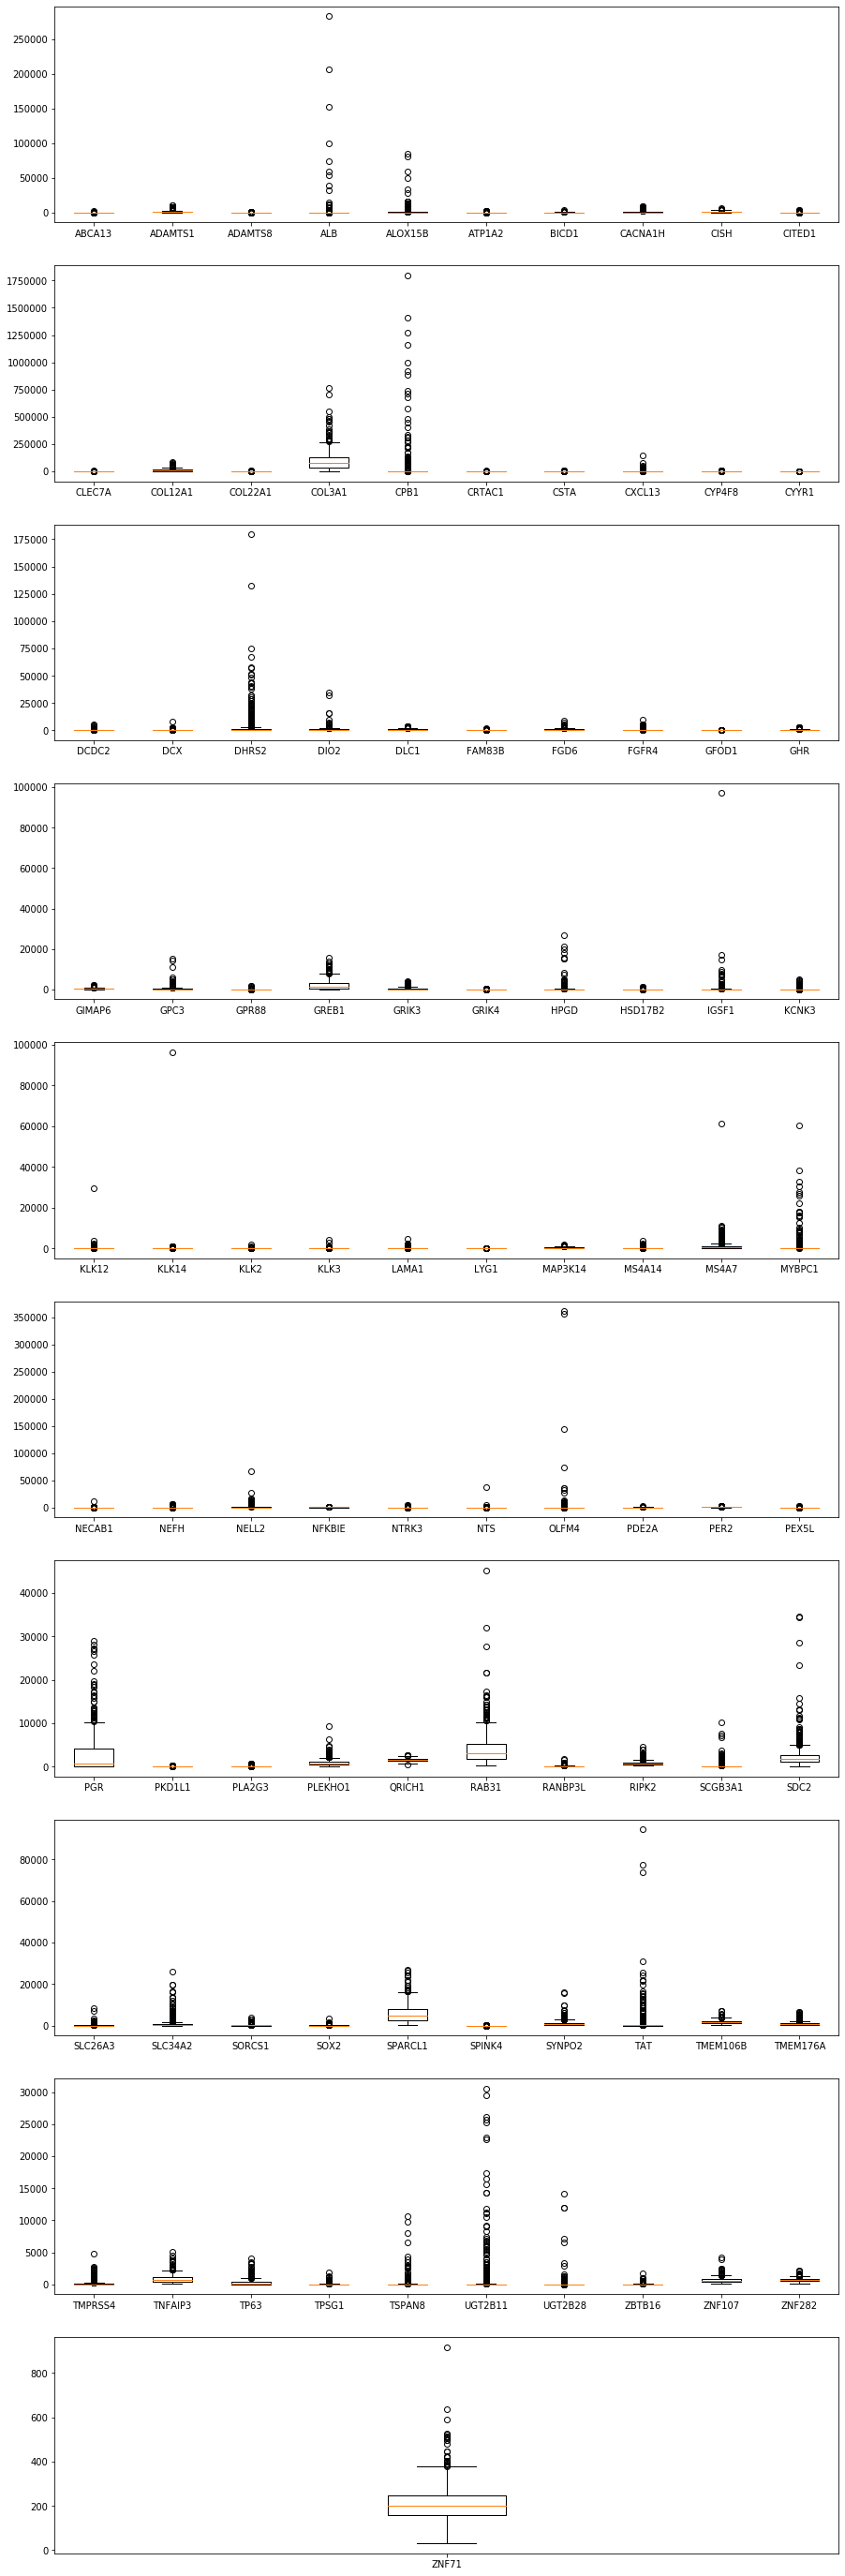

In [129]:
plot_feature_distributions(patients, genes_expressed)

In [130]:
# todo: analyze distributions, decide what to do with outliers

***
**Feature processing**
***

Let's try to reduce the dimensionality of the input space, i.e. the linear mapping of our D-dimensional input into a K-dimensional space K<=D that best represents the original data.

In [ ]:
# INCOMPLETE
# PCA decomposition of original gene list
# we want to verify that the pre-selected genes are linearly independent

pca = PCA()
pca.fit(genes_list)
PCA(copy=True, iterated_power='auto', n_components=None,
    random_state=None, svd_solver='auto', tol=0.0, whiten=False)

# Explained variance by PCA
# print(pca.explained_variance_)

# Singular values of PCA
# print(pca.singular_values_)

y_pos = np.arange(len(pca.singular_values_))
plt.bar(y_pos, pca.singular_values_, align='center', alpha=0.5)
plt.ylabel('Values')
plt.xlabel('Principal components')
plt.title('PCA - Singular values')
plt.show()

#
#pca.n_components = 2
#X_reduced = pca.fit_transform(X)
# X_reduced.shape

***
**Clustering**
***

In [ ]:
X = pdx.drop("label", axis=1)
y = pdx.label

clus = cluster.AgglomerativeClustering(n_clusters=7)  # , affinity='manhattan', linkage='average')
predicted = clus.fit_predict(X)

# calculate score
score = metrics.adjusted_rand_score(y, predicted)
print(score)
# accuracy, f2 = performance(predicted)

***
**Spectral Clustering**
***

In [ ]:
clustering = cluster.SpectralClustering(assign_labels="discretize", random_state=0).fit(X)
print("predicted labels : " + str(clustering.labels_))
print("true labels :      " + str(pdx_labeled.values))
print("Score : " + str(metrics.adjusted_rand_score(x, clustering.labels_)))

***
**K-Means**
***

In [ ]:
kmeans = cluster.KMeans(n_clusters=4, random_state=0).fit(X)
print("predicted labels : " + str(kmeans.labels_))
print("true labels :      " + str(pdx_labeled.values))
print("Score : " + str(metrics.adjusted_rand_score(y, kmeans.labels_)))

In [ ]:
# we should rather evaluate with the metrics.adjusted_rand_score function 

def performance(labels):
    '''Evaluate performance of predicted cluster compared to pre-selected gene list'''
    # get gene list
    geneNP = genes_list.loc[:,'dht':'p4'].astype(int).values  # replace with Boolean values
    
    nb_clusters = len(np.unique(labels))
    accuracy = np.zeros([nb_clusters, 3])
    f2 =  np.zeros([nb_clusters, 3])
    beta = 2
    for i in np.arange(nb_clusters):
        label = np.zeros_like(labels)
        label[labels == i] = 1
        for j in np.arange(geneNP.shape[1]):
            # plot confusion matrices
            
            #cm = metrics.confusion_matrix(geneNP[:,j], label)
            #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            #fig, ax = plt.subplots()
            #im = ax.imshow(cm, interpolation='nearest')
            #ax.figure.colorbar(im, ax=ax)
            accuracy[i,j] = np.mean(geneNP[:,j]==label)
            f2[i,j] = metrics.fbeta_score(geneNP[:,j], label, beta)
    return accuracy, f2
        

***
**Principal Component Analysis**
***